In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse
import pylib.qsvt_angles as qsvt_a
import cvxpy as cp

33119
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [9]:
def reproduce_env(x, a):
    Nx = len(x)
    res_pol = np.zeros(Nx)
    Nc = len(a)
    for ix in range(Nx):
        res_pol[ix] = 0.
        for ii in range(Nc):
            res_pol[ix] += a[ii] * np.cos((2*ii) * np.arccos(x[ix]))
    return res_pol


def include_sign(half_env):
    N_pos_env = len(half_env)
    Nh = 2*N_pos_env
    phis_half = np.zeros(Nh)

    counter_el = -1
    for ii in range(N_pos_env-1):
        v1 = half_env[N_pos_env - ii - 1]

        counter_el += 1
        phis_half[Nh-counter_el-1] = v1

        counter_el += 1
        v2 = half_env[N_pos_env - ii - 2]
        phis_half[Nh-counter_el-1] = -(v1+v2)/2.
    return phis_half


def compute_inverse_function(phis_comp, kappa, coef_norm):
    # ---------------------------------------------------
    def compute_inverse_function_at_x1(x1):
        # - W-matrix -
        xs = 1j*np.sqrt(1 - x1**2)
        W = np.array([
            [x1, xs],
            [xs, x1]
        ], dtype = complex)

        # - sequence of rotations -
        U = np.array(Rphi[0])
        for ia in range(1,Na):
            U = U.dot(W).dot(Rphi[ia])
        return U[0,0].real
    # ---------------------------------------------------
    Na = len(phis_comp)

    # x-grid:
    Nx = 101
    x_grid_1 = np.linspace(-1.0, -1.0/kappa)
    x_grid_2 = np.linspace(1.0/kappa, 1.0, Nx)
    x_grid = np.concatenate((x_grid_1, x_grid_2))
    Nx = len(x_grid)

    # rotation matrices:
    Rphi = np.zeros((Na,2,2), dtype = complex)
    for ia in range(Na):
        ephi = np.exp(1j * phis_comp[ia])
        Rphi[ia,0,0] = ephi
        Rphi[ia,1,1] = np.conjugate(ephi)

    # computation:
    inv_qsvt = np.zeros(Nx)
    for ix in range(Nx):
        inv_qsvt[ix] = compute_inverse_function_at_x1(x_grid[ix])
    inv_qsvt *= kappa * coef_norm

    # --- the reference case ---
    inv_ref = 1./x_grid

    return inv_qsvt, inv_ref, x_grid

In [18]:
# -------------------------------------------------------------
# --- Parameters for the estimation of the matrix inversion ---
# -------------------------------------------------------------

# chosen condition number:
kappa_qsvt_ = 1000

# normalization coefficient:
coef_norm_ = 8.

# parameters for the reconstruction of the QSVT angles:
coefs_ = np.array([
    -4.360801e-01, -5.226961e-01, -6.770340e-02,
    2.464178e-02,  2.474306e-03, -9.172489e-04 
])

# the coefficient to compute the half of the positive peak of QSVT angles:
coef_Na  = 225./40.

# the coefficient to comput the maximum amplitude of the QSVT angles:
coef_A  = 3.117e-03 * 40.

<IPython.core.display.Javascript object>


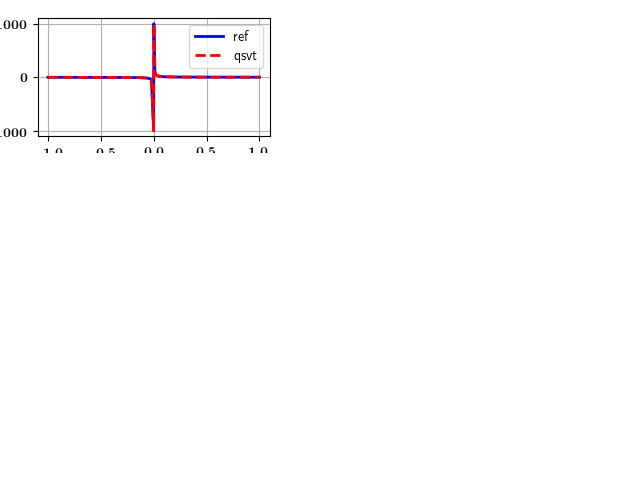

max. abs. err: 1.525e+00


In [19]:
# ------------------------------------------------------------------------------
# --- Estimate the QSVT angles ---
# ------------------------------------------------------------------------------

# - the number of peaks in the QSVT angles -
N_env_pos = int(coef_Na * kappa_qsvt_)
grid_xa = np.linspace(0.0, 1.0, N_env_pos)

# - Absolute amplitudes of the QSVT angles -
half_env = reproduce_env(grid_xa, coefs_)
del grid_xa

# - Include the sign of the QSVT angels -
phis_half = include_sign(half_env)
phis_appr = np.concatenate(( phis_half, np.flip(phis_half) ))

# - Rescale the QSVT angles -
max_ampl = coef_A / kappa_qsvt_
phis_appr *= max_ampl

# --- Compute the inverse function using the sequence of 2x2 rotations ---
# - Correct the angles to compute the inverse function -
phis_appr[0]  += np.pi/4.
phis_appr[-1] += np.pi/4.

# - the refence inverse function -
inv_qsvt, inv_ref, x_grid = compute_inverse_function(
    phis_appr, kappa_qsvt_, coef_norm_
)

# - Plot the inverse function -
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid, inv_ref,  color="b", linewidth = 2, linestyle='-',  label = "ref")
ax.plot(x_grid, inv_qsvt, color="r", linewidth = 2, linestyle='--', label = "qsvt")
plt.xlabel('i')
plt.ylabel("phis")
# plt.xlim(-5, 5)
ax.legend()
plt.grid(True)
plt.show()

N = len(inv_qsvt)
rr = range(0, N)
max_abs_err = np.max(np.abs(inv_qsvt[rr] - inv_ref[rr]))
print("max. abs. err: {:0.3e}".format(max_abs_err))

del inv_qsvt, inv_ref, x_grid

In [ ]:
# ----------------------------------------------------------------
# --- Store the QSVT angles to .hdf5 file ---
# ----------------------------------------------------------------
# The stored angles can be use to compute the matrix inversion
# using the QSVT circuit.
# ---
# The condition number of the target matrix should be of the order of
# the parameter kappa_qsvt_.
# ----------------------------------------------------------------

# - Correct the QSVT angles -
phis_save = np.array(phis_appr)
phis_save[0]  -= np.pi/4.
phis_save[-1] -= np.pi/4.
phis_save     += np.pi/2.

# - Store the QSVT angles -